# Sentiment Analysis - Supervised Learning Classification Models

We have already discussed that sentiment analysis, also popularly known as opinion analysis or opinion mining is one of the most important applications of NLP. The key idea is to predict the potential sentiment of a body of text based on the textual content. In this sub-unit, we will be exploring supervised learning models. 

![](sentiment_cover.png)

Another way to build a model to understand the text content and predict the sentiment of the text based reviews is to use supervised machine learning. To be more specific, we will be using classification models for solving this problem. We will be building an automated sentiment text classification system in subsequent sections. The major steps to achieve this are mentioned as follows.

1.	Prepare train and test datasets (optionally a validation dataset)
2.	Pre-process and normalize text documents
3.	Feature Engineering 
4.	Model training
5.	Model prediction and evaluation

These are the major steps for building our system. Optionally the last step would be to deploy the model in your server or on the cloud. The following figure shows a detailed workflow for building a standard text classification system with supervised learning (classification) models.

![](sentiment_classifier_workflow.png)


In our scenario, documents indicate the movie reviews and classes indicate the review sentiments which can either be positive or negative making it a binary classification problem. We will build models using both traditional machine learning methods and newer deep learning in the subsequent sections. 

# Load and View Dataset

In [2]:
import pandas as pd

dataset = pd.read_csv(r'../Unit 11 - Sentiment Analysis - Unsupervised Learning/movie_reviews.csv.bz2', compression='bz2')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


In [3]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Build Train and Test Datasets

In [5]:
# build train and test datasets
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

# Text Wrangling & Normalization

In [10]:
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re
import nltk
import numpy as np

ps = nltk.porter.PorterStemmer()
stop_words = nltk.corpus.stopwords.words('english')
stop_words.remove('no')
stop_words.remove('but')
stop_words.remove('not')


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def expand_contractions(text):
    return contractions.fix(text)


def simple_stemming(text, stemmer=ps):
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text


def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text


def remove_stopwords(text, is_lower_case=False, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


def pre_process_document(document):
    
    # strip HTML
    document = strip_html_tags(document)
    
    # lower case
    document = document.lower()
    
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    
    # remove accented characters
    document = remove_accented_chars(document)
    
    # expand contractions    
    document = expand_contractions(document)
               
    # remove special characters and\or digits    
    # insert spaces between special characters to isolate them    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)  

    # stemming text
    document = simple_stemming(document)      
    
    # remove stopwords
    document = remove_stopwords(document, is_lower_case=True, stopwords=stop_words)
        
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    document = document.strip()
    
    return document


pre_process_corpus = np.vectorize(pre_process_document)

In [11]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

Wall time: 12min 34s


# Traditional Supervised Machine Learning Models

## Feature Engineering

In [15]:
%%time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# build BOW features on train reviews
cv = CountVectorizer(binary=False, min_df=5, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(norm_train_reviews)


# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=5, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(norm_train_reviews)

Wall time: 52.2 s


In [16]:
%%time

# transform test reviews into features
cv_test_features = cv.transform(norm_test_reviews)
tv_test_features = tv.transform(norm_test_reviews)

Wall time: 10.4 s


In [17]:
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (35000, 138566)  Test features shape: (15000, 138566)
TFIDF model:> Train features shape: (35000, 138566)  Test features shape: (15000, 138566)


## Model Training, Prediction and Performance Evaluation

### Try out Logistic Regression



In [47]:
%%time

# Logistic Regression model on BOW features
from sklearn.linear_model import LogisticRegression

# instantiate model
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42)

# train model
lr.fit(cv_train_features, train_sentiments)

# predict on test data
lr_bow_predictions = lr.predict(cv_test_features)

Wall time: 27.1 s


In [48]:
import model_evaluation_utils as meu

meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_bow_predictions,
                                      classes=['positive', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.9041
Precision: 0.9041
Recall: 0.9041
F1 Score: 0.9041

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.90      0.90      0.90      7510
    negative       0.90      0.90      0.90      7490

   micro avg       0.90      0.90      0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6793      717
        negative        721     6769


In [51]:
%%time

# Logistic Regression model on TF-IDF features

# train model
lr.fit(tv_train_features, train_sentiments)

# predict on test data
lr_tfidf_predictions = lr.predict(tv_test_features)

Wall time: 6.06 s


In [52]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_tfidf_predictions,
                                      classes=['positive', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.9036
Precision: 0.9037
Recall: 0.9036
F1 Score: 0.9036

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.90      0.91      0.90      7510
    negative       0.91      0.90      0.90      7490

   micro avg       0.90      0.90      0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6834      676
        negative        770     6720


### Try out Random Forest


In [56]:
%%time

# Random Forest model on BOW features
from sklearn.ensemble import RandomForestClassifier

# instantiate model
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

# train model
rf.fit(cv_train_features, train_sentiments)

# predict on test data
rf_bow_predictions = rf.predict(cv_test_features)

Wall time: 6min 48s


In [57]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=rf_bow_predictions,
                                      classes=['positive', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.8734
Precision: 0.8735
Recall: 0.8734
F1 Score: 0.8734

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.87      0.88      0.87      7510
    negative       0.88      0.87      0.87      7490

   micro avg       0.87      0.87      0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6618      892
        negative       1007     6483


In [58]:
%%time

# Random Forest model on TF-IDF features

# train model
rf.fit(tv_train_features, train_sentiments)

# predict on test data
rf_tfidf_predictions = rf.predict(tv_test_features)

Wall time: 6min 1s


In [59]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=rf_tfidf_predictions,
                                      classes=['positive', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.8761
Precision: 0.8761
Recall: 0.8761
F1 Score: 0.8761

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.87      0.88      0.88      7510
    negative       0.88      0.87      0.88      7490

   micro avg       0.88      0.88      0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6599      911
        negative        947     6543


# Newer Supervised Deep Learning Models

In [61]:
import gensim
import keras
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder
from keras.layers.normalization import BatchNormalization

## Prediction class label encoding

In [63]:
le = LabelEncoder()
num_classes=2 
# tokenize train reviews & encode train labels
tokenized_train = [nltk.word_tokenize(text)
                       for text in norm_train_reviews]
y_tr = le.fit_transform(train_sentiments)
y_train = keras.utils.to_categorical(y_tr, num_classes)
# tokenize test reviews & encode test labels
tokenized_test = [nltk.word_tokenize(text)
                       for text in norm_test_reviews]
y_ts = le.fit_transform(test_sentiments)
y_test = keras.utils.to_categorical(y_ts, num_classes)

In [64]:
# print class label encoding map and encoded labels
print('Sentiment class label map:', dict(zip(le.classes_, le.transform(le.classes_))))
print('Sample test label transformation:\n'+'-'*35,
      '\nActual Labels:', test_sentiments[:3], '\nEncoded Labels:', y_ts[:3], 
      '\nOne hot encoded Labels:\n', y_test[:3])

Sentiment class label map: {'negative': 0, 'positive': 1}
Sample test label transformation:
----------------------------------- 
Actual Labels: ['negative' 'positive' 'negative'] 
Encoded Labels: [0 1 0] 
One hot encoded Labels:
 [[1. 0.]
 [0. 1.]
 [1. 0.]]


## Feature Engineering with word embeddings

In [10]:
%%time
# build word2vec model
w2v_num_features = 512
w2v_model = gensim.models.Word2Vec(tokenized_train, size=w2v_num_features, window=150,
                                   min_count=10, sample=1e-3, workers=16)    

CPU times: user 36min 27s, sys: 598 ms, total: 36min 27s
Wall time: 2min 19s


In [13]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [14]:
# generate averaged word vector features from word2vec model
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=tokenized_train, model=w2v_model,
                                                     num_features=w2v_num_features)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=tokenized_test, model=w2v_model,
                                                    num_features=w2v_num_features)

In [15]:
# feature engineering with GloVe model
train_nlp = [tn.nlp_vec(item) for item in norm_train_reviews]
train_glove_features = np.array([item.vector for item in train_nlp])

test_nlp = [tn.nlp_vec(item) for item in norm_test_reviews]
test_glove_features = np.array([item.vector for item in test_nlp])

In [16]:
print('Word2Vec model:> Train features shape:', avg_wv_train_features.shape, ' Test features shape:', avg_wv_test_features.shape)
print('GloVe model:> Train features shape:', train_glove_features.shape, ' Test features shape:', test_glove_features.shape)

Word2Vec model:> Train features shape: (35000, 512)  Test features shape: (15000, 512)
GloVe model:> Train features shape: (35000, 300)  Test features shape: (15000, 300)


## Modeling with deep neural networks 

### Building Deep neural network architecture

In [65]:
def construct_deepnn_architecture(num_input_features):
    dnn_model = Sequential()
    dnn_model.add(Dense(512, input_shape=(num_input_features,), kernel_initializer='glorot_uniform'))
    dnn_model.add(BatchNormalization())
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(512, kernel_initializer='glorot_uniform'))
    dnn_model.add(BatchNormalization())
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(512, kernel_initializer='glorot_uniform'))
    dnn_model.add(BatchNormalization())
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(2))
    dnn_model.add(Activation('softmax'))

    dnn_model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return dnn_model

In [68]:
w2v_dnn = construct_deepnn_architecture(num_input_features=w2v_num_features)

### Visualize sample deep architecture

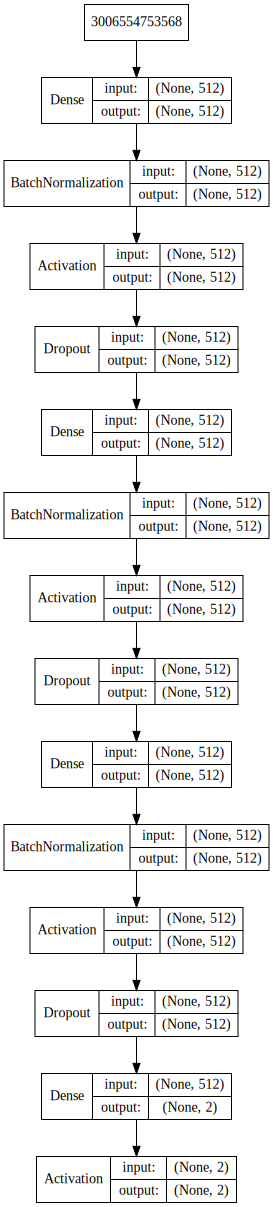

In [69]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(w2v_dnn, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

### Model Training, Prediction and Performance Evaluation

In [101]:
batch_size = 100
w2v_dnn.fit(avg_wv_train_features, y_train, epochs=10, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)

Train on 31500 samples, validate on 3500 samples
Epoch 1/10
31500/31500 [==============================] - 8s 250us/step - loss: 0.3378 - acc: 0.8598 - val_loss: 0.3114 - val_acc: 0.8714
Epoch 2/10
31500/31500 [==============================] - 6s 204us/step - loss: 0.2877 - acc: 0.8808 - val_loss: 0.2968 - val_acc: 0.8806
Epoch 3/10
31500/31500 [==============================] - 6s 204us/step - loss: 0.2766 - acc: 0.8854 - val_loss: 0.3043 - val_acc: 0.8726
Epoch 4/10
31500/31500 [==============================] - 6s 203us/step - loss: 0.2702 - acc: 0.8888 - val_loss: 0.2964 - val_acc: 0.8786
Epoch 5/10
31500/31500 [==============================] - 6s 204us/step - loss: 0.2656 - acc: 0.8896 - val_loss: 0.3058 - val_acc: 0.8794
Epoch 6/10
31500/31500 [==============================] - 6s 204us/step - loss: 0.2618 - acc: 0.8916 - val_loss: 0.3128 - val_acc: 0.8694
Epoch 7/10
31500/31500 [==============================] - 6s 203us/step - loss: 0.2562 - acc: 0.8924 - val_loss: 0.3009 - v

In [102]:
y_pred = w2v_dnn.predict_classes(avg_wv_test_features)
predictions = le.inverse_transform(y_pred) 

/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [103]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions, 
                                      classes=['positive', 'negative'])  

Model Performance metrics:
------------------------------
Accuracy: 0.8817
Precision: 0.8818
Recall: 0.8817
F1 Score: 0.8817

Model Classification report:
------------------------------
             precision    recall  f1-score   support

   positive       0.87      0.89      0.88      7510
   negative       0.89      0.87      0.88      7490

avg / total       0.88      0.88      0.88     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6704      806
        negative        969     6521


In [106]:
glove_dnn = construct_deepnn_architecture(num_input_features=300)

In [107]:
batch_size = 100
glove_dnn.fit(train_glove_features, y_train, epochs=10, batch_size=batch_size, 
              shuffle=True, validation_split=0.1, verbose=1)

Train on 31500 samples, validate on 3500 samples
Epoch 1/10
31500/31500 [==============================] - 8s 246us/step - loss: 0.4116 - acc: 0.8204 - val_loss: 0.4466 - val_acc: 0.8066
Epoch 2/10
31500/31500 [==============================] - 6s 194us/step - loss: 0.3348 - acc: 0.8547 - val_loss: 0.3553 - val_acc: 0.8449
Epoch 3/10
31500/31500 [==============================] - 6s 193us/step - loss: 0.3134 - acc: 0.8643 - val_loss: 0.3433 - val_acc: 0.8489
Epoch 4/10
31500/31500 [==============================] - 6s 195us/step - loss: 0.2973 - acc: 0.8714 - val_loss: 0.3539 - val_acc: 0.8474
Epoch 5/10
31500/31500 [==============================] - 6s 195us/step - loss: 0.2863 - acc: 0.8791 - val_loss: 0.3429 - val_acc: 0.8480
Epoch 6/10
31500/31500 [==============================] - 6s 195us/step - loss: 0.2746 - acc: 0.8850 - val_loss: 0.3737 - val_acc: 0.8477
Epoch 7/10
31500/31500 [==============================] - 6s 196us/step - loss: 0.2611 - acc: 0.8889 - val_loss: 0.3854 - v

In [108]:
y_pred = glove_dnn.predict_classes(test_glove_features)
predictions = le.inverse_transform(y_pred) 

/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [109]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions, 
                                      classes=['positive', 'negative'])  

Model Performance metrics:
------------------------------
Accuracy: 0.8596
Precision: 0.8596
Recall: 0.8596
F1 Score: 0.8596

Model Classification report:
------------------------------
             precision    recall  f1-score   support

   positive       0.86      0.86      0.86      7510
   negative       0.86      0.85      0.86      7490

avg / total       0.86      0.86      0.86     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6496     1014
        negative       1092     6398
